In [226]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [227]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [228]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

/home/marcino/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Contract'>

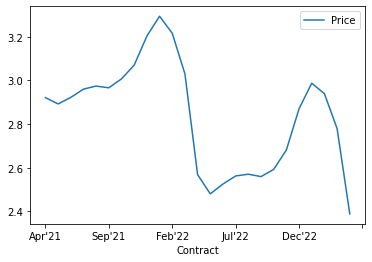

In [229]:
df.plot(x='Contract', y='Price')

In [230]:
N=12 # number of months to use
max_storage_capacity=100000
max_daily_injection=2000
max_daily_withdrawal=4000

In [231]:
# injection / withdrawal quantities
Q=[ [None]*N for _ in range(N) ]
for i in range(N):
    for j in range(N):
        Q[i][j] = pulp.LpVariable(f'V[{i},{j}]', lowBound=0, cat='Integer')

In [232]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))
prices = list(df.Price)

In [233]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*N

# for each injection month
for i in range(N):
    total_injection[i] = pulp.lpSum([Q[i][j] for j in range(N)])*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    daily_injection[i] = total_injection[i] / days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*N

# for each drawing month
for j in range(N):
    total_draw[j] = pulp.lpSum([Q[i][j] for i in range(N)])*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    daily_draw[j] = total_draw[j] / days[j]

total_storage=[None]*N
for i in range(N):
    if i == 0:
        total_storage[i] = total_injection[i] - total_draw[i]
    else:
        total_storage[i] = total_injection[i] - total_draw[i] + total_storage[i-1]

In [234]:
storage_value_lp = pulp.LpProblem("NoRatchets", pulp.LpMaximize)

# target function
storage_value_lp += pulp.lpSum(withdrawal_credit) + pulp.lpSum(injection_charges)

# add constraints
for i in range(N):
    storage_value_lp += total_storage[i] >= 0
    storage_value_lp += total_storage[i] <= max_storage_capacity
    storage_value_lp += daily_injection[i] <= max_daily_injection
    storage_value_lp += daily_draw[i] <= max_daily_withdrawal
    

In [235]:
storage_value_lp.solve()
pulp.LpStatus[storage_value_lp.status]

'Optimal'

In [236]:
for variable in storage_value_lp.variables():
    if variable.varValue != 0.0:
        print( "{} = {}".format(variable.name, variable.varValue) )

V_0,4_ = 6.0
V_1,7_ = 6.0
V_10,11_ = 5.0
V_11,10_ = 5.0
V_5,8_ = 6.0
V_7,9_ = 6.0
V_8,9_ = 6.0
V_9,0_ = 2.0


In [237]:
print( pulp.value(storage_value_lp.objective) )

39520.0


In [238]:
df[ 'Gas in Storge' ] = 0
df.loc[ range(N), 'Gas in Storge' ] = list(map(lambda x: pulp.value(x), total_storage))

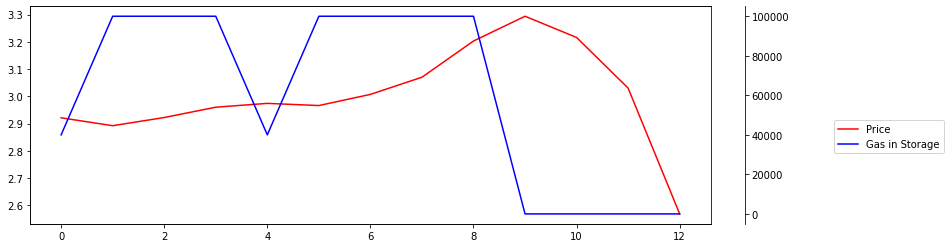

In [239]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df.loc[0:N].Price.plot(ax=ax, style='r-')
df.loc[0:N]['Gas in Storge'].plot(ax=ax3, style='b-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0]], ['Price','Gas in Storage'], bbox_to_anchor=(1.35, 0.5))